We need a model that: 
* Turns PCAP data into a noise=y/time series system
* Needs to have a control variable and a feedback

* $X$ is cell concentration measured by $OD$
* $dX = X \mu dt$ where $\mu$ is a growth rate at start / early times
* $X$ is more like a $tanh$ / $erfc$ asymptotic-limited at late times
* What form is $ \mu (S) $? vs. $S$ the sugar controlled with feed rate
* Feed rate for target $\mu$ is $F(t) = \mu C exp(\mu t)$
* Control over $F$ is only when you start (when S is 0 after 4-6 hours), and how long you push for target growth rate (10-20 hours) then drop to a constant for (up to 24 hours total)
* Need a function $X(\mu, X_final)

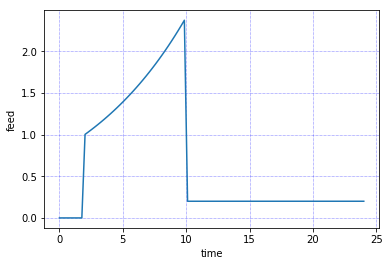

In [153]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

t = np.linspace(0., 24, 96)

def feed(time, mu, tstart, tend, Fend):
    early = (t <= tstart)
    late = (t > tend)
    earlyval = np.zeros(time.shape) * early
    lateval = Fend * np.ones(time.shape) * late
    expfeed = np.exp((time-tstart)* mu) * (np.logical_not(np.logical_or(early,late)))
    retval = earlyval + expfeed + lateval
    return retval

mu = .11
tstart = 2
tend = 10
Fend = .2
plt.plot(t, feed(t,mu, tstart, tend, Fend), '-')
plt.xlabel('time')
plt.ylabel('feed')
plt.grid(color='b', linestyle=':', linewidth=.5)


Value of mu: 0.374466534194


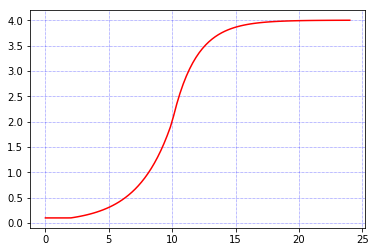

In [160]:
def ODfunc(time, ODinit, tfeed, ODinduce, tinduce, ODfinal):
    # Calculate some derived quantities
    tfinal = max(t)
    # ODmu in unknown - pick a value that
    mu = np.log(ODinduce / ODinit) / (tinduce - tfeed)
    print("Value of mu:", mu)
    # Create masks for the early, feed, induce phases
    early = (t <= tfeed)
    late = (t > tinduce)
    mid = (np.logical_not(np.logical_or(early,late)))
    # Create the values that match the model
    earlyval = ODinit * np.ones(time.shape) * early
    midval = (ODinit*np.exp((time-tfeed)* mu)) * mid
    lateval = (ODfinal - (ODfinal - ODinduce)*np.exp(-(time-tinduce) * (mu*20) / (tfinal - tinduce))) * late
    retval = earlyval + midval + lateval
    return retval

ODinit = .1
tinduce = 10
ODinduce = 2
ODfinal = 4
tfeed = tstart

# tinduce = tend
plt.plot(t, ODfunc(t, ODinit, tfeed, ODinduce, tinduce, ODfinal), '-', color='r')
plt.grid(color='b', linestyle=':', linewidth=.5)


In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Next thing to do:
# - input experiment results: ODfinal
# - infer OD params: ODinduce, tinduce

t_data = pd.read_csv("LimonenePCAPdata.csv", index_col=0)
#t_data = t_data[t_data.PCAPpaper != "n"]
t_data.shape
t_data.head(5)

# Infer a fit between inducer Level, inducer OD, and ODfinal
X = t_data[['InducedOD', 'InducerLevel', 'Ecoli Strain']]
print(X)
y = t_data[['Optical Density']]
print(y)

# Induced OD: H (2.5) M(1.2) L(.2)

      InducedOD InducerLevel Ecoli Strain
Line                                     
2X-Hh         H            h           2X
2X-Hl         H            l           2X
2X-Hm         H            m           2X
2X-Lh         L            h           2X
2X-Ll         L            l           2X
2X-Lm         L            m           2X
2X-Mh         M            h           2X
2X-Ml         M            l           2X
2X-Mm         M            m           2X
A-Hh          H            h            A
A-Hl          H            l            A
A-Hm          H            m            A
A-Lh          L            h            A
A-Ll          L            l            A
A-Lm          L            m            A
A-Mh          M            h            A
A-Ml          M            l            A
A-Mm          M            m            A
B-Hh          H            h            B
B-Hl          H            l            B
B-Hm          H            m            B
B-Lh          L            h      

In [257]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

label_enc = LabelEncoder()
# print(X)
Xarr = np.array(X)[0:27,:]
# print(Xarr)
Xstr = label_enc.fit_transform(Xarr[:,0])
Xiod = label_enc.fit_transform(Xarr[:,1])
Xinl = label_enc.fit_transform(Xarr[:,2])
Xenc = np.transpose(np.array([Xstr, Xiod, Xinl]))
Xohenc = OneHotEncoder(sparse = False).fit_transform(Xenc)

lr = LinearRegression(fit_intercept=True)
y_fit = np.array(y)[0:27,:]
lr.fit(Xohenc, y_fit)
y_pred = lr.predict(Xohenc)
print(y_pred - y_fit)
print(lr.coef_)

[[ 0.36034778]
 [-1.22091333]
 [ 0.21908556]
 [ 0.44864   ]
 [-0.84395111]
 [ 0.62804778]
 [ 0.69286556]
 [-0.94039556]
 [ 0.65627333]
 [-0.00143444]
 [-0.23735556]
 [-0.03402667]
 [-0.20980222]
 [ 0.76560667]
 [-0.45639444]
 [-0.25357667]
 [ 0.25849222]
 [ 0.16849111]
 [ 0.05138333]
 [ 0.51345222]
 [ 0.34946111]
 [-0.52232444]
 [ 1.13375444]
 [-0.94357667]
 [-0.56609889]
 [ 0.57131   ]
 [-0.58736111]]
[[-0.40582667  0.46713556 -0.06130889 -0.06404889  0.04069     0.02335889
   0.02869222  0.18358    -0.21227222]]
